# Прототип модели предсказания количества заказов такси на следующий час для компании "Четенькое такси"

Задача - добиться значения метрики RMSE менее 48.

______

#### Данное исследование разделим на несколько частей.
______________________
### Часть 1: Подготовка данных
* [1. Загрузка библиотек, загрузка данных и ресесплирование данных.](#1-bullet)

### Часть 2: Анализ данных
* [1. Предобработка данных.](#2-bullet)

### Часть 3: Обучение моделей
* [1. Создание новых признаков.](#3-bullet)
* [2. Разделение данных на обучающую, валидационную и тестовую выборки, выделение целевого признака.](#4-bullet)
* [3. Поиск и обучение лучшей модели с различными гиперпараметрами на на валидационной выборке на основании метрики RMSE..](#5-bullet)

### Часть 4: Проверака моделей
* [1. Проверка моделей на тестовой выборке на основании метрики RMSE.](#6-bullet)

#### Описание данных:

- datetime - Дата и время заказа.
- num_orders - Число заказов.

#### 1-bullet
#### Часть 1: Подготовка данных
1. Загрузка библиотек, загрузка данных и ресесплирование данных.

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# прочитаем файл, сразу же преоборазовав даты и время в нужный формат
# при этом дату и время сделаем индексом и сделаем ресеплирование по 1 часу
df = pd.read_csv('/datasets/taxi.csv', 
                 index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()

# получим общую информацию и откроем 5 строк таблицы
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


- получили временной ряд с 1 марта 2018 года по 31 августа 2018 года. всего 4416 наблюдений. все значения имеют целочисленный тип.

#### 2-bullet
#### Часть 2: Анализ данных
1. Предобработка данных.

In [3]:
# узнаем характеристи значений
display(df.describe())

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


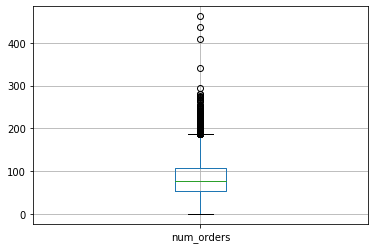

In [4]:
# построим ящик с усами
df.boxplot()
plt.show()

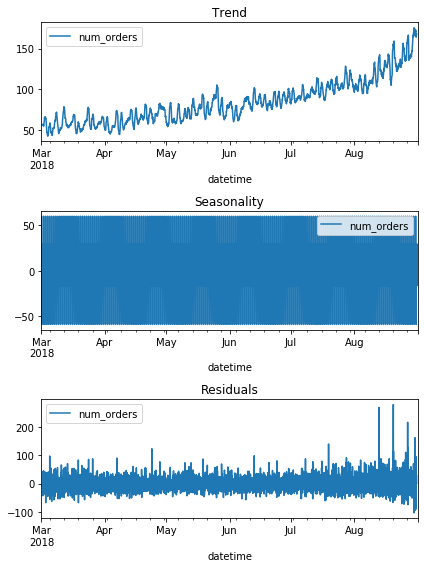

In [5]:
# применим к нашим данным функцию разложения временного ряда
# на тренд, сезонность и шум
decomposed = seasonal_decompose(df)

# построим графики
plt.figure(figsize=(6, 8))
# график тренда
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
# график сезонности
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
# график шумов
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

- пришли к выводу, что наши данные не имеют сезонности, зато имеется четкий восходящий тренд.
- при этом также имеется и остаток декомпозиции преимущественно в небольшом диапазоне, лишь со второй половины августа этот диапазон расширяется.

#### 3-bullet 
#### Часть 3: Обучение моделей
1. Создание новых признаков.

- создадим функцию, которая на вход принимает данные, величину сдвига, размер окна и добавляет к данным календарные признаки (в нашем случае мы можем добавить день недели и час), отстающие значения и скользящее среднее. 

In [6]:
def make_features(data, max_lag, rolling_mean_size):
    # создадим календарные признаки
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # создадим цикл для установки сдвига(отставания) с задаваемой величиной
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = (data['num_orders'].
                                      shift(lag))
    # создадим признак скользящего среднего с задаваемой величиной
    data['rolling_mean'] = (data['num_orders'].
                            shift().rolling(rolling_mean_size).
                            mean())

In [7]:
# применим функцию применив произвольные данные
# для того, чтобы посмотреть день и час у выбросов
make_features(df, 1, 2)

# посмотрим признаки значений более 290
print(df.query('num_orders > 290'))

                     num_orders  dayofweek  hour  lag_1  rolling_mean
datetime                                                             
2018-08-13 02:00:00         437          0     2  273.0         216.5
2018-08-20 02:00:00         462          0     2  272.0         236.0
2018-08-27 02:00:00         408          0     2  222.0         242.5
2018-08-27 04:00:00         295          0     4  208.0         308.0
2018-08-30 17:00:00         342          3    17  254.0         205.0


- пришли к выводу, что все выбивающиеся значения были в августе, в основном по понедельникам в 2 часа. 
- пришли к выводу, что эти значения не являются выбросами, поскольку являются составной частью восходящего тренда и объяснимы сезоном отпусков.

In [8]:
# применим функцию применив произвольные данные
# для проверки работоспособности
make_features(df, 2, 1)

#### 4-bullet 
#### Часть 3: Обучение моделей
2. Разделение данных на обучающую, валидационную и тестовую выборки, выделение целевого признака.

- создадим функцию, которая на вход будет принимать данные, а возвращать обучающую, валидационную и тестовую выборки. при этом размер тествой выборки зададим 10%, перемешивание данных отключим, удалим пропуски в признаках, а также получим признаки и целевой признак.

In [8]:
# сохраним значение параметра random_state в переменной
my_random_state = 123

# создадим функцию, которая на вход будет принимать данные
# а возвращать обучающую, валидационную и тестовую выборки
def make_train_test(data):
    # разделим данные на обучающие с валидационной и тестовые
    train_valid, test = train_test_split(df, shuffle=False, 
                                         test_size=0.1, 
                                         random_state=my_random_state)
    # удалим пропуски
    train_valid = train_valid.dropna()
    # разделим данные на обучающую и валидационную выборки
    train, valid = train_test_split(train_valid, shuffle=False, 
                                    test_size=0.2, 
                                    random_state=my_random_state)
    
    # для всех выборок выделим целевой признак и признаки.
    target_train = train['num_orders']
    features_train = train.drop(['num_orders'] , axis=1)
    
    target_valid = valid['num_orders']
    features_valid = valid.drop(['num_orders'] , axis=1)
        
    target_test = test['num_orders']
    features_test = test.drop(['num_orders'] , axis=1)
    
    return (features_train, features_valid, features_test, 
            target_train, target_valid, target_test)

In [9]:
# применим функцию для проверки работоспособности
(features_train, features_valid, features_test, 
 target_train, target_valid, target_test) = make_train_test(df)

#### 5-bullet 
#### Часть 3: Обучение моделей
3. Поиск и обучение лучшей модели с различными гиперпараметрами на на валидационной выборке на основании метрики RMSE.

- путем изменения сдига и размера окна в данных найдем лучшую модель линейной регрессии на валидационной выборке на основании метрики RMSE. 

In [11]:
best_model = None
best_result = 10000
best_max_lag = 0
best_rolling_mean_size = 0
for lag in range(1, 31):
    for rolling in range (1, 31):
        # создадим признаки при помощи функции
        make_features(df, max_lag = lag, 
                      rolling_mean_size = rolling)
        # создадим выборки при помощи функции
        (features_train, features_valid, 
         features_test, target_train, 
         target_valid, target_test) = make_train_test(df)
        
        # сохраним модель с искомыми гиперпараметрами
        model = LinearRegression(normalize=True)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = mean_squared_error(target_valid, predicted_valid) ** 0.5
        
        # найдем лучшую модель
        if result < best_result:
            best_model = model
            best_result = result
            best_max_lag = lag
            best_rolling_mean_size = rolling                     
            
# выведем на экран качество лучшей модели, количество окон и сдвиг
print("RMSE наилучшей модели на валидационной выборке: %.2f" % best_result, 
      "Сдвиг:", best_max_lag, "Размер окна:", best_rolling_mean_size)

RMSE наилучшей модели на валидационной выборке: 33.33 Сдвиг: 24 Размер окна: 22


- получили RMSE наилучшей модели линейной регрессии на валидационной выборке при следующих параметрах данных: сдвиг - 24, размер окна - 22.

- далее аналогичным образом подберем параметры сдвига, размера окна данных для модели решающего дерева, а также найдем гиперпараметр глубины.

In [12]:
best_model = None
best_result = 10000
best_depth = 0
best_max_lag = 0
best_rolling_mean_size = 0
for lag in range(1, 11):
    for rolling in range (1, 11):
        for depth in range(1, 31):
            # создадим признаки
            make_features(df, max_lag = lag, 
                          rolling_mean_size = rolling)
            # разделим данные на выборки
            (features_train, features_valid, 
             features_test, target_train, 
             target_valid, target_test) = make_train_test(df)
            # инициализируем модель решающего дерева
            model = DecisionTreeRegressor(random_state=my_random_state, 
                                          max_depth=depth)
            model.fit(features_train, target_train)
            # получим предсказания на валидационной выборке 
            predicted_valid = model.predict(features_valid) 
            # найдем значения метрики         
            result = mean_squared_error(target_valid, predicted_valid) ** 0.5
            if result < best_result:
                best_model = model
                best_result = result
                best_depth = depth
                best_max_lag = lag
                best_rolling_mean_size = rolling

# выведем на экран качество лучшей модели, сдвиг, размер окна и глубину
print("RMSE наилучшей модели на валидационной выборке: %.2f" % best_result, 
      "Сдвиг:", best_max_lag, "Размер окна:", best_rolling_mean_size,
      "Максимальная глубина:", best_depth)

RMSE наилучшей модели на обучающей выборке: 35.49 Сдвиг: 1 Размер окна: 10 Максимальная глубина: 5


- получили RMSE наилучшей модели на валидационной выборке: 35.49 при следующих параметрах данных: сдвиг - 1, размер окна - 10 и максимальная глубина - 5.

- далее аналогичным образом подберем параметры и гиперпараметры для модели LGBMRegressor. 

In [13]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
best_max_lag = 0
best_rolling_mean_size = 0
for lag in range(1, 3):
    for rolling in range (1, 3):
        for est in range(10, 15):
            for depth in range (10, 15):
                # создадим признаки
                make_features(df, max_lag = lag, 
                              rolling_mean_size = rolling)
                # разделим данные на выборки
                (features_train, features_valid, 
                 features_test, target_train, 
                 target_valid, target_test) = make_train_test(df)
                # инициализируем модель 
                model = LGBMRegressor(random_state=my_random_state, 
                                      n_estimators=est, 
                                      max_depth=depth)
                # обучим модель
                model.fit(features_train, target_train) 
                # получим предсказания по обучающей выборке 
                predicted_valid = model.predict(features_valid) 
                # найдем значения метрики         
                result = mean_squared_error(target_valid, predicted_valid) ** 0.5
        
                # найдем лучшую модель
                if result < best_result:
                    best_model = model
                    best_result = result
                    best_est = est
                    best_depth = depth
                    best_max_lag = lag
                    best_rolling_mean_size = rolling
            
# выведем на экран качество лучшей модели, количество деревьев и глубинe
print("RMSE наилучшей модели на валидационной выборке: %.2f" % best_result,
      "Сдвиг:", best_max_lag, "Размер окна:", best_rolling_mean_size,
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth) 

RMSE наилучшей модели на валидационной выборке: 37.59 Сдвиг: 1 Размер окна: 2 Количество деревьев: 14 Максимальная глубина: 10


- получили RMSE наилучшей модели на валидационной выборке: 40.77 при следующих параметрах: Сдвиг - 1, Размер окна - 2, Количество деревьев - 14, Максимальная глубина - 13.

#### 6-bullet 
#### Часть 4: Проверака моделей
1. Проверка моделей на тестовой выборке на основании метрики RMSE.

- проверим линейную регрессию на тестовой выборке.

In [10]:
# создадим признаки с полученными параметрами
# свдига и размера окна
make_features(df, max_lag = 24, 
              rolling_mean_size = 22)

# разделим данные на выборки
(features_train, features_valid, 
 features_test, target_train, 
 target_valid, target_test) = make_train_test(df)
        
# сохраним модель с искомыми гиперпараметрами,
# обучим и получим предсказания на тестовой выборке
model = LinearRegression(normalize=True)
model.fit(features_train, target_train)
predicted_test_1 = model.predict(features_test)
result_1 = mean_squared_error(target_test, predicted_test_1) ** 0.5
print("RMSE модели линейной регрессии на тестовой выборке: %.2f" % result_1)

RMSE модели линейной регрессии на тестовой выборке: 46.29


- получили RMSE модели линейной регрессии на тестовой выборке 46.29, что удовлетворяет поставленной задаче.
- далее проверим модель решающего дерева на тествой выборке.

In [11]:
# создадим признаки с полученными параметрами
# свдига и размера окна
make_features(df, max_lag = 1, 
              rolling_mean_size = 10)

# разделим данные на выборки
(features_train, features_valid, 
 features_test, target_train, 
 target_valid, target_test) = make_train_test(df)

# иницализируем модель решающего дерева
# c полученным гиперпараметром и обучим
model = DecisionTreeRegressor(random_state=my_random_state, 
                              max_depth=5)
model.fit(features_train, target_train)
# получим предсказания на тестовой выборке 
predicted_test = model.predict(features_test) 
result_2 = mean_squared_error(target_test, predicted_test) ** 0.5
print("RMSE модели решающего дерева на тестовой выборке: %.2f" % result_2)

RMSE модели решающего дерева на тестовой выборке: 51.76


- получили RMSE модели решающего дерева на тестовой выборке: 51.67, что не удовлетворяет поставленной задаче.
- далее проверим модель LGBMRegressor на тестовой выборке.

In [12]:
# создадим признаки с полученными параметрами
# свдига и размера окна
make_features(df, max_lag = 1, 
              rolling_mean_size = 2)

# разделим данные на выборки
(features_train, features_valid, 
 features_test, target_train, 
 target_valid, target_test) = make_train_test(df)

# сохраним модель с искомыми гиперпараметрами
model = LGBMRegressor(random_state=my_random_state, 
                      n_estimators=14, 
                      max_depth=13)
# обучим модель
model.fit(features_train, target_train) 
# получим предсказания по тестовой выборке 
predicted_test = model.predict(features_test) 
# найдем значение метрики         
result_3 = mean_squared_error(target_test, predicted_test) ** 0.5
print("RMSE модели LGBMRegressor на тестовой выборке: %.2f" % result_3)

RMSE модели LGBMRegressor на тестовой выборке: 66.03


- получили RMSE модели LGBMRegressor на тестовой выборке 66,03, что не удовлетворяет поставленной задаче.
- выведем полученные результаты на графике.

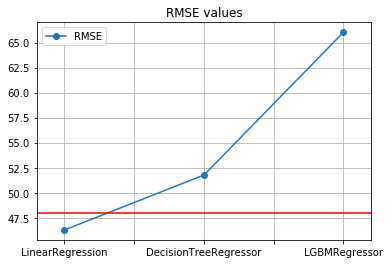

In [13]:
# создадим словарь, в который запишем значения метрики
# каждой модели
models_RMSE = {'LinearRegression': [result_1],
                'DecisionTreeRegressor': [result_2],
                'LGBMRegressor': [result_3]}

# создадим датафрейм 
models_RMSE = pd.DataFrame(models_RMSE, index=['RMSE']).T

# построим графики показателей качества и времени
models_RMSE['RMSE'].plot(style='o-', xlim=(-0.2, 2.2), 
                         legend=True, grid=True)
plt.axhline(y=48, color='r', linestyle='-')
plt.title('RMSE values')
plt.show()

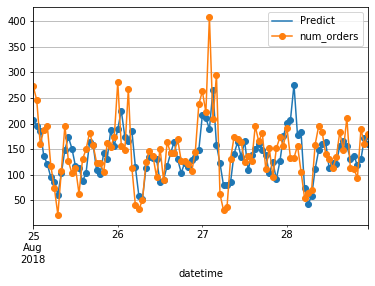

In [14]:
# придадим предсказаниям вид сириес, при этом в качестве индекса
# используем индекс целевого признака
predicted_test_1 = pd.Series(predicted_test_1, index=target_test.index, name='Predict')
# выберем временной интервал
predicted_test_1 = predicted_test_1['2018-08-25':'2018-08-28']
# построим график
predicted_test_1.plot(style='o-', legend=True, grid=True)

# выберем тот же временной интервал
target_test = target_test['2018-08-25':'2018-08-28']
# построим график
target_test.plot(style='o-', legend=True, grid=True)
plt.show()

## Общий вывод:


- пришли к выводу, что для решения поставленной задачи подходит только модель линейная регрессия и только после подбора параметров сдвига и размера окна данных.
- остальные модели не смогли достичь поставленной задачи.
- при сверке полученных предсказаний с правильными ответами видим, что основные промахи происходят на пиках, т.е. разворотах тренда. Другими словами модель работает в рамках тренда как скользящее среднее, сглаживая пики и чуть запаздывая.